In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pickle
import os
import sys
import torch
import torch.nn as nn
from omegaconf import OmegaConf
from monai.metrics import DiceMetric
from sklearn import metrics
from torch.utils.data import DataLoader
from matplotlib.patches import Ellipse
from matplotlib.colors import ListedColormap
palette = sns.color_palette("Set2")
sns.set_theme(style="whitegrid")
palette[1], palette[2] = palette[2], palette[1]
palette[3], palette[-1] = palette[-1], palette[3]

In [2]:
REPO_PATH = "/workspace/repositories/DSSQ/src"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
sys.path.append(REPO_PATH)

from models import get_unet
from data_utils import get_eval_data
from adapters import DimReductAdapter, DimReductModuleWrapper

### Load basic config
# DATA_KEY = "prostate"
DATA_KEY = "heart"
EXTRA_DESCRIPTION = "_base"
# EXTRA_DESCRIPTION = "_scmode"
LOG = False
LOAD_ONLY_PRESENT = True
VALIDATION = True  # If false makes validation set be the training one
MODE = "eval"
N_DIMS = [32, 960]
models = ["monai-64-4-4", "swinunetr"]
dim_red_modes = ["IPCA", "PCA", "AVG_POOL"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_conf(unet_name="", iteration=0, data_key="prostate"):
    cfg = OmegaConf.load(f"{REPO_PATH}/configs/conf.yaml")
    OmegaConf.update(cfg, "run.iteration", iteration)
    OmegaConf.update(cfg, "run.data_key", data_key)
    args = unet_name.split("-")
    cfg.wandb.log = LOG
    cfg.unet[data_key].pre = unet_name
    cfg.unet[data_key].arch = args[0]
    cfg.unet[data_key].n_filters_init = int(args[1]) if "monai" in unet_name else None
    cfg.unet[data_key].training.load_only_present = LOAD_ONLY_PRESENT
    cfg.unet[data_key].training.validation = VALIDATION
    cfg.unet[data_key].training.batch_size = 32
    cfg.wandb.project = f"{data_key}_{unet_name}_{iteration}{EXTRA_DESCRIPTION}"
    if MODE == "eval":
        cfg.format = "numpy"
    layer_names = None
    if "monai" in unet_name:
        cfg.unet[data_key].depth = int(args[2])
        cfg.unet[data_key].num_res_units = int(args[3])
        layer_names = [
            f'model.{"1.submodule." * i}0.conv' for i in range(cfg.unet[DATA_KEY].depth)
        ]
        layer_names.append("model.1.submodule.1.submodule.2.0.conv")
    elif unet_name == "swinunetr":
        layer_names = ["encoder2", "encoder3", "encoder4", "encoder10"]
    return cfg, layer_names

@torch.no_grad()
def eval_data(cfg, model, dataset):
    if hasattr(model, "empty_data"):
        model.empty_data()
    model.eval()
    dice_scores = []
    seg_masks = []
    dm = DiceMetric(ignore_empty=True, include_background=False)
    dataloader = DataLoader(
        dataset,
        batch_size=cfg.unet.prostate.training.batch_size,
        shuffle=False,
        drop_last=False,
    )
    for batch in dataloader:
        input_ = batch["input"].cuda()
        target = batch["target"]
        out = model(input_)
        seg_mask = torch.argmax(out, dim=1).unsqueeze(1)
        batch_dices = dm(seg_mask.detach().cpu(), target)
        seg_masks.append(seg_mask)
        dice_scores.append(batch_dices)

    dice_scores = torch.cat(dice_scores, dim=0).squeeze().detach().cpu().numpy()
    seg_masks = torch.cat(seg_masks, dim=0).detach().cpu()
    return dice_scores, seg_masks

swin_iter_p = 0
unet_iter_p = 1
swin_iter_h = 3
unet_iter_h = 3
swin_iter_hs = 0
unet_iter_hs = 2

if DATA_KEY == "prostate":
    unet_iter, swin_iter = unet_iter_p, swin_iter_p
    train_vendors = ["siemens"]
    test_vendors = ["siemens", "philips", "ge"]
elif DATA_KEY == "heart" and EXTRA_DESCRIPTION == "_base":
    unet_iter, swin_iter = unet_iter_h, swin_iter_h
    train_vendors = ["siemens"]
    test_vendors = ["siemens", "philips", "ge"]
elif DATA_KEY == "heart" and EXTRA_DESCRIPTION == "_scmode":
    unet_iter, swin_iter = unet_iter_hs, swin_iter_hs
    train_vendors = ["train"]
    test_vendors = ["train", "test"]

#### Collect dice, segmentation masks, and MD data

In [3]:
all_eval_data = {}
dices_vendor = {}

for ven in train_vendors:
    dices_vendor[f"{ven}_train"] = {}
    cfg, _ = load_conf(data_key=DATA_KEY)
    cfg.unet[DATA_KEY].training.subset = "training"
    if EXTRA_DESCRIPTION == "_base":
        cfg.unet[DATA_KEY].training.vendor = ven
    if EXTRA_DESCRIPTION == "_scmode":
        cfg.unet[DATA_KEY].training.train_scanner = True
        cfg.unet[DATA_KEY].training.mode = "scanner"
    data = get_eval_data(train_set=False, val_set=False, eval_set=True, cfg=cfg)
    all_eval_data[f"{ven}_train"] = data['eval']
    for model in models:
        dices_vendor[f"{ven}_train"][model] = {}
        if "monai" in model:
            iteration = unet_iter
        else:
            iteration = swin_iter
        cfg, layer_names = load_conf(model, iteration=iteration, data_key=DATA_KEY)
        model_base, state_dict = get_unet(cfg, return_state_dict=True)
        model_base = model_base.to(device)
        model_base.eval()
        adapters = [
            DimReductAdapter(layer_name, 2, cfg.unet[DATA_KEY].training.batch_size,
                             mode="PCA", pre_fit=True, fit_gaussian=True,
                             project=cfg.wandb.project
                             ) for layer_name in layer_names
        ]
        adapters = nn.ModuleList(adapters)
        model_adapted = DimReductModuleWrapper(model=model_base, adapters=adapters)
        model_adapted = model_adapted.to(device)
        model_adapted.eval()
        model_base_dices, model_base_segs = eval_data(cfg, model_adapted, data["eval"])
        dices_vendor[f"{ven}_train"][model]['DS'] = model_base_dices
        dices_vendor[f"{ven}_train"][model]['seg'] = model_base_segs
        dices_vendor[f"{ven}_train"][model]['dim_red_features'] = {adapter.swivel: np.vstack(adapter.reduced_acts) for adapter in model_adapted.adapters}

for ven in test_vendors:
    dices_vendor[ven] = {}
    cfg, _ = load_conf(data_key=DATA_KEY)
    cfg.unet[DATA_KEY].training.subset = (
        "validation" if ven in train_vendors else False
    )
    if EXTRA_DESCRIPTION == "_base":
        cfg.unet[DATA_KEY].training.vendor = ven
    if EXTRA_DESCRIPTION == "_scmode":
        cfg.unet[DATA_KEY].training.train_scanner = True if ven == "train" else False
        cfg.unet[DATA_KEY].training.mode = "scanner"
    data = get_eval_data(eval_set=True, cfg=cfg)
    all_eval_data[ven] = data['eval']
    for model in models:
        dices_vendor[ven][model] = {}
        if "monai" in model:
            iteration = unet_iter
        else:
            iteration = swin_iter
        cfg, layer_names = load_conf(model, iteration=iteration, data_key=DATA_KEY)
        model_base, state_dict = get_unet(cfg, return_state_dict=True)
        model_base = model_base.to(device)
        model_base.eval()
        adapters = [
            DimReductAdapter(layer_name, 2, cfg.unet[DATA_KEY].training.batch_size,
                             mode="PCA", pre_fit=True, fit_gaussian=False, store_acts=True,
                             project=cfg.wandb.project
                             ) for layer_name in layer_names
        ]
        adapters = nn.ModuleList(adapters)
        model_adapted = DimReductModuleWrapper(model=model_base, adapters=adapters)
        model_adapted = model_adapted.to(device)
        model_adapted.eval()
        model_base_dices, model_base_segs = eval_data(cfg, model_adapted, data["eval"])
        dices_vendor[ven][model]['DS'] = model_base_dices
        dices_vendor[ven][model]['seg'] = model_base_segs
        dices_vendor[ven][model]['dim_red_features'] = {adapter.swivel: np.vstack(adapter.reduced_acts) for adapter in model_adapted.adapters}
        dices_vendor[ven][model]['md'] = {adapter.swivel: torch.cat(adapter.distances, dim=0).detach().cpu().numpy() for adapter in model_adapted.adapters}

Loading evaluation M&M dataset for vendor siemens ...
Loading data... vendor mode
Data loaded. Number of slices: 1050
Loaded model from epoch 47 and path:
/workspace/out/weights/heart_monai-64-4-4_heart_monai-64-4-4_3_base_3_best.pt


/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


Loaded model from epoch 55 and path:
/workspace/out/weights/heart_swinunetr_heart_swinunetr_3_base_3_best.pt
Loading evaluation M&M dataset for vendor siemens ...
Loading data... vendor mode
Data loaded. Number of slices: 264
Loaded model from epoch 47 and path:
/workspace/out/weights/heart_monai-64-4-4_heart_monai-64-4-4_3_base_3_best.pt


/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


Loaded model from epoch 55 and path:
/workspace/out/weights/heart_swinunetr_heart_swinunetr_3_base_3_best.pt
Loading evaluation M&M dataset for vendor philips ...
Loading data... vendor mode
Data loaded. Number of slices: 528
Loaded model from epoch 47 and path:
/workspace/out/weights/heart_monai-64-4-4_heart_monai-64-4-4_3_base_3_best.pt


/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


Loaded model from epoch 55 and path:
/workspace/out/weights/heart_swinunetr_heart_swinunetr_3_base_3_best.pt
Loading evaluation M&M dataset for vendor ge ...
Loading data... vendor mode
Data loaded. Number of slices: 315
Loaded model from epoch 47 and path:
/workspace/out/weights/heart_monai-64-4-4_heart_monai-64-4-4_3_base_3_best.pt


/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


Loaded model from epoch 55 and path:
/workspace/out/weights/heart_swinunetr_heart_swinunetr_3_base_3_best.pt


#### Collect Mahalanobis Distance data

In [4]:
@torch.no_grad()
def eval_pmri_MD(cfg, model, dataset):
    ''' Mahalanobis distance (MD) evaluation '''
    assert isinstance(model, DimReductModuleWrapper), "Model must be a DimReductModuleWrapper"
    model.empty_data()
    model.eval()
    dataloader = DataLoader(dataset, batch_size=cfg.unet.prostate.training.batch_size,
                            shuffle=False, drop_last=False)
    for batch in dataloader:
        input_ = batch['input']
        model(input_.cuda())

    md = {adapter.swivel: torch.cat(adapter.distances, dim=0).detach().cpu().numpy() for adapter in model.adapters}
    return md

for ven in train_vendors:
    cfg, _ = load_conf(data_key=DATA_KEY)
    cfg.unet[DATA_KEY].training.subset = "training"
    if EXTRA_DESCRIPTION == "_base":
        cfg.unet[DATA_KEY].training.vendor = ven
    data = all_eval_data[f"{ven}_train"]
    for model in models:
        if "monai" in model:
            iteration = unet_iter
            mode = "AVG_POOL"
            n_dims = 1e4
        else:
            iteration = swin_iter
            mode = "AVG_POOL"
            n_dims = 1e4
        cfg, layer_names = load_conf(model, iteration=iteration, data_key=DATA_KEY)
        model_base, state_dict = get_unet(cfg, return_state_dict=True)
        model_base = model_base.to(device)
        model_base.eval()
        adapters = [
            DimReductAdapter(layer_name, n_dims, cfg.unet[DATA_KEY].training.batch_size,
                             mode=mode, pre_fit=True, fit_gaussian=False,
                             project=cfg.wandb.project
                             ) for layer_name in layer_names
        ]
        adapters = nn.ModuleList(adapters)
        model_adapted = DimReductModuleWrapper(model=model_base, adapters=adapters)
        model_adapted = model_adapted.to(device)
        model_adapted.eval()
        md_data = eval_pmri_MD(cfg, model_adapted, data)
        dices_vendor[f"{ven}_train"][model]['md_avg'] = md_data

for ven in test_vendors:
    cfg, _ = load_conf(data_key=DATA_KEY)
    cfg.unet[DATA_KEY].training.subset = (
        "validation" if ven in train_vendors else False
    )
    if EXTRA_DESCRIPTION == "_base":
        cfg.unet[DATA_KEY].training.vendor = ven
    data = all_eval_data[ven]
    for model in models:
        if "monai" in model:
            iteration = unet_iter
            mode = "AVG_POOL"
            n_dims = 1e4
        else:
            iteration = swin_iter
            mode = "AVG_POOL"
            n_dims = 1e4
        cfg, layer_names = load_conf(model, iteration=iteration, data_key=DATA_KEY)
        model_base, state_dict = get_unet(cfg, return_state_dict=True)
        model_base = model_base.to(device)
        model_base.eval()
        adapters = [
            DimReductAdapter(layer_name, n_dims, cfg.unet[DATA_KEY].training.batch_size,
                             mode=mode, pre_fit=True, fit_gaussian=False,
                             project=cfg.wandb.project
                             ) for layer_name in layer_names
        ]
        adapters = nn.ModuleList(adapters)
        model_adapted = DimReductModuleWrapper(model=model_base, adapters=adapters)
        model_adapted = model_adapted.to(device)
        model_adapted.eval()
        md_data = eval_pmri_MD(cfg, model_adapted, data)
        dices_vendor[ven][model]['md_avg'] = md_data

Loaded model from epoch 47 and path:
/workspace/out/weights/heart_monai-64-4-4_heart_monai-64-4-4_3_base_3_best.pt


/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


Loaded model from epoch 55 and path:
/workspace/out/weights/heart_swinunetr_heart_swinunetr_3_base_3_best.pt
Loaded model from epoch 47 and path:
/workspace/out/weights/heart_monai-64-4-4_heart_monai-64-4-4_3_base_3_best.pt
Loaded model from epoch 55 and path:
/workspace/out/weights/heart_swinunetr_heart_swinunetr_3_base_3_best.pt
Loaded model from epoch 47 and path:
/workspace/out/weights/heart_monai-64-4-4_heart_monai-64-4-4_3_base_3_best.pt
Loaded model from epoch 55 and path:
/workspace/out/weights/heart_swinunetr_heart_swinunetr_3_base_3_best.pt
Loaded model from epoch 47 and path:
/workspace/out/weights/heart_monai-64-4-4_heart_monai-64-4-4_3_base_3_best.pt
Loaded model from epoch 55 and path:
/workspace/out/weights/heart_swinunetr_heart_swinunetr_3_base_3_best.pt


#### AURCi PLOT

In [5]:
def plot_aurc_i(data, higher_conf_better=True):
    aurcs_i = {}
    fig, ax = plt.subplots(2, 4, figsize=(30, 15))
    colors = palette[:3][::-1]
    for i, model in enumerate(models):
        if model == "swinunetr":
            layers = ["encoder2", "encoder3", "encoder4", "encoder10"]
        else:
            layers = [f'model.{"1.submodule." * i}0.conv' for i in range(4)]
        for j, layer in enumerate(layers):
            for k, vendor in enumerate(test_vendors[::-1]):
                dices = data[vendor][model]['DS']
                risks = 1 - dices
                n_samples = len(risks)
                counts = np.arange(1, n_samples + 1)
                coverages = counts / n_samples
                if "monai" in model:
                    confs = data[vendor][model]['md'][layer]
                else:
                    confs = data[vendor][model]['md_avg'][layer]
                # Sort by confidence scores (highest first)
                idx_sorted = np.argsort(confs)
                if higher_conf_better:
                    idx_sorted = idx_sorted[::-1]
                cum_risks = np.cumsum(risks[idx_sorted])
                selective_risks = cum_risks / counts
                # Full coverage (starting point)
                coverages = np.insert(coverages, 0, 0)
                selective_risks = np.insert(selective_risks, 0, 0)
                aurc = metrics.auc(coverages[::-1], selective_risks[::-1])
                aurcs_i[f"{vendor}_{model}_{layer}"] = aurc
                ax[i,j].plot(
                    coverages,
                    selective_risks,
                    label=f"{vendor} AURC = {aurc:.4f}",
                    color=colors[k],
                    marker="o",
                    markersize=2,
                )
                ax[i,j].fill_between(coverages, selective_risks, color=colors[k], alpha=0.3)
                ax[i,j].set_title(f"{'U-Net' if 'monai' in model else 'SwinUNETR'} - Layer {j+1}")
                ax[i,j].set_xlabel("Coverage")
                ax[i,j].set_ylabel("Selective Risk")
                ax[i,j].set_xlim([0, 1])
                ax[i,j].set_ylim([0, 1])
                ax[i,j].legend(loc="upper right")

    plt.show()
    return aurcs_i

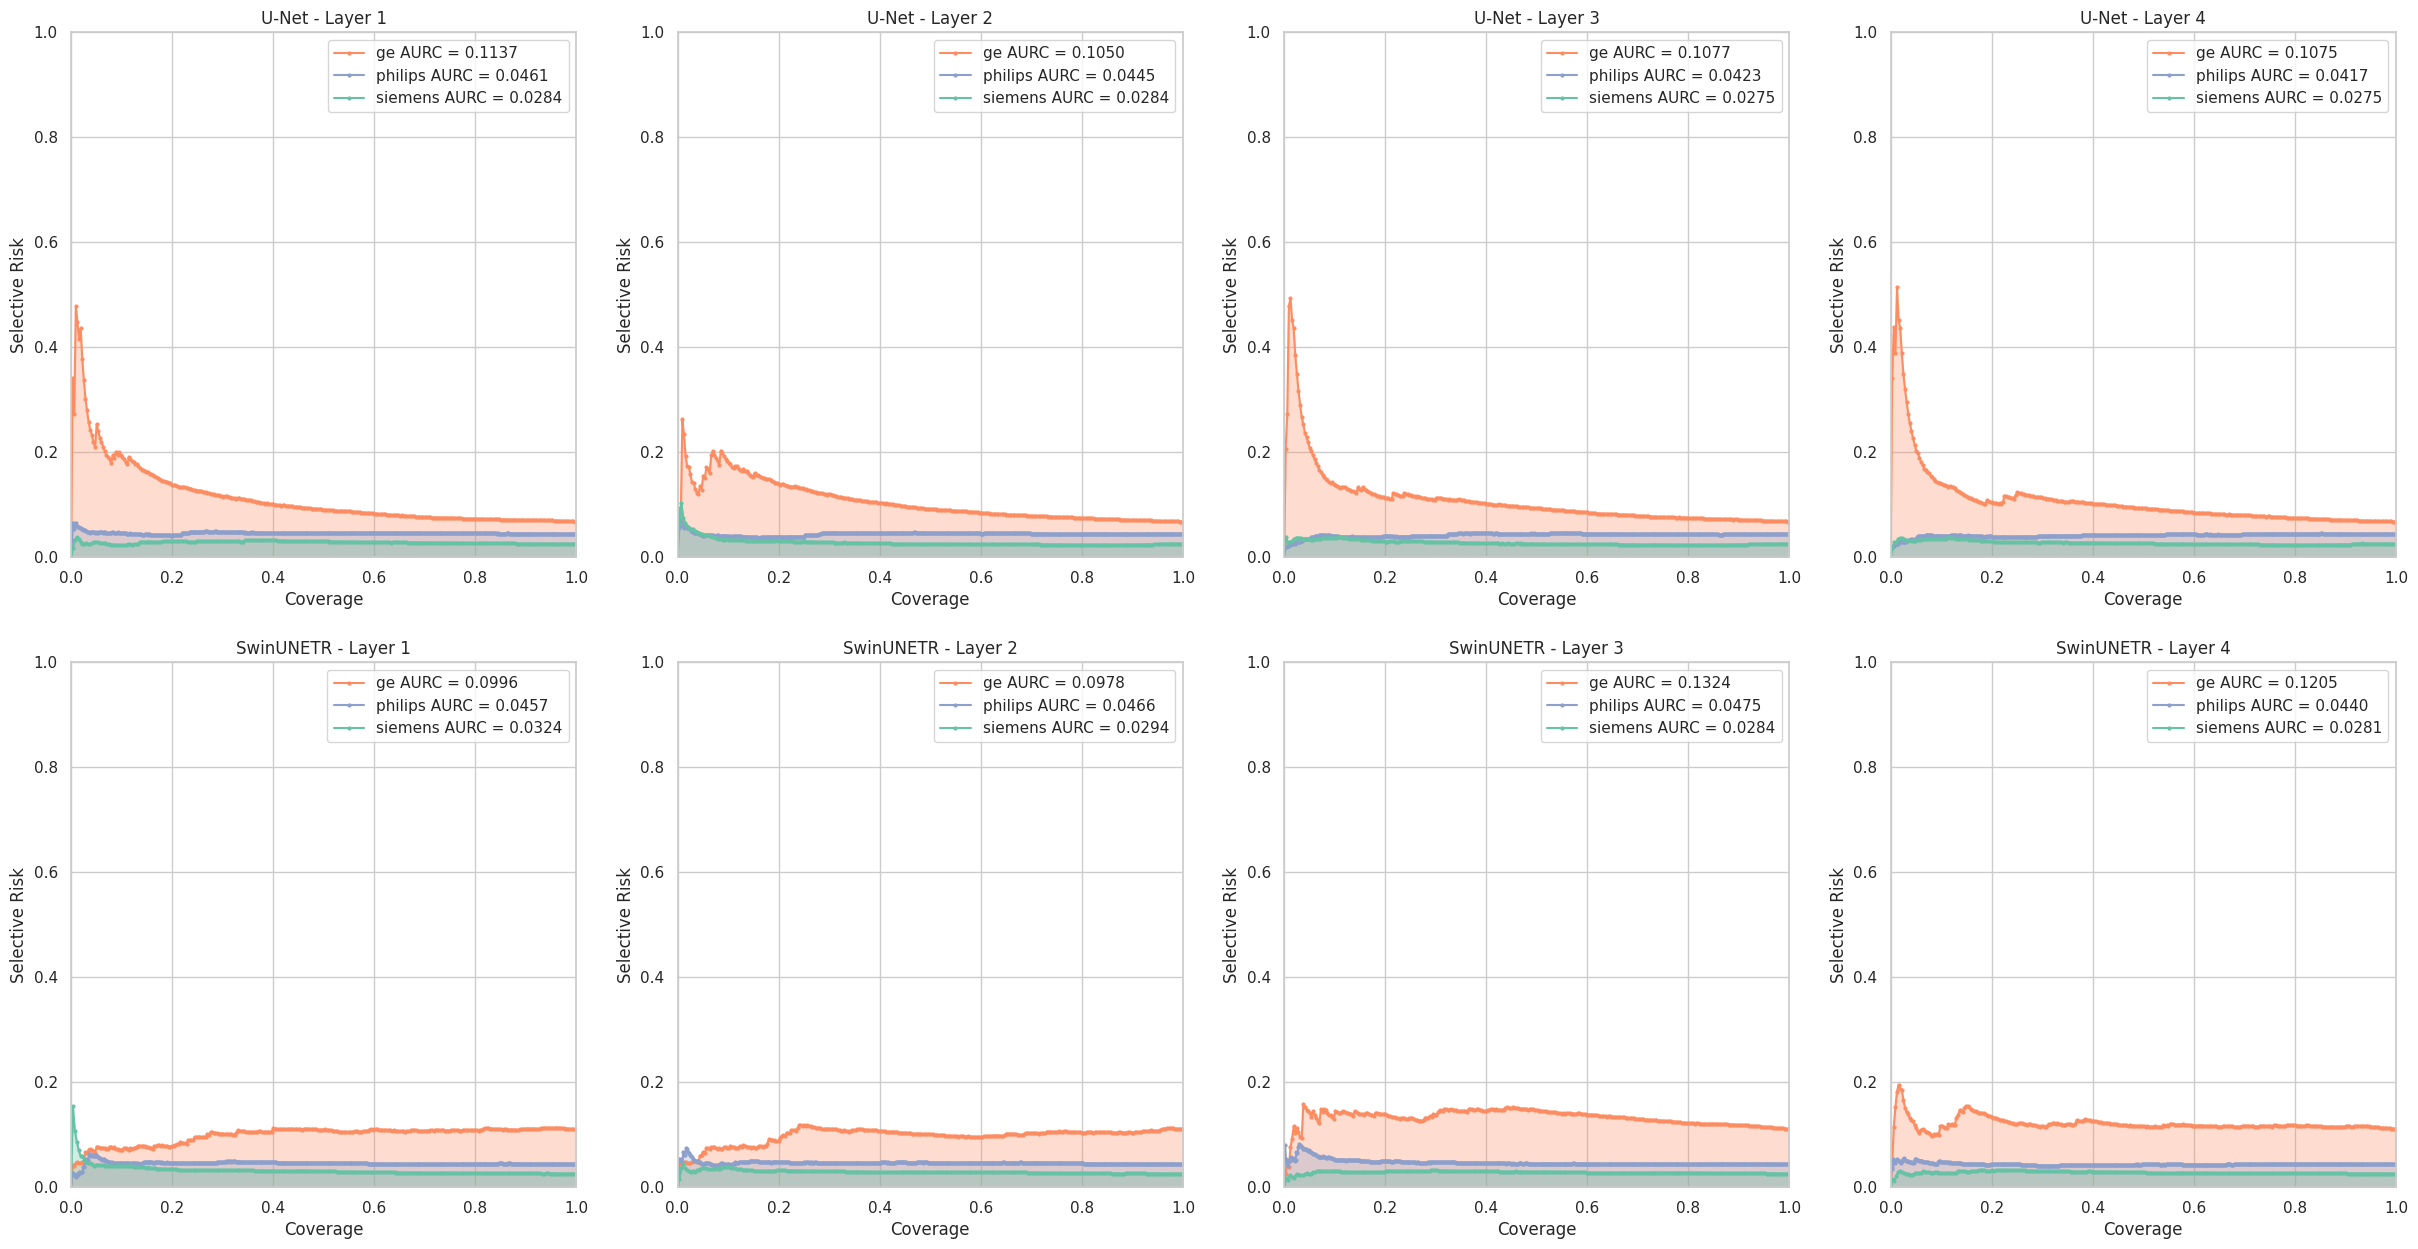

In [6]:
aurci = plot_aurc_i(dices_vendor, higher_conf_better=True)

#### PCA plots

In [7]:
def plot_multi_pca_features(data):
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    colors = ['red', 'blue', 'green', 'gray'][::-1]
    colors = palette[3:4] + palette[:3]
    models = ["monai-64-4-4", "swinunetr"]
    for i, model in enumerate(models):
        if model == "monai-64-4-4":
            layers = ["model.0.conv", "model.1.submodule.1.submodule.1.submodule.0.conv"]
        else:
            layers = ["encoder2", "encoder10"]
        for j, lay in enumerate(layers):
            for k, ven in enumerate(data):
                tmp_data = dices_vendor[ven][model]["dim_red_features"][lay]
                ms = 10 if "train" in ven else 20
                alph = 0.5 if "train" in ven else 0.7
                axes[i, j].scatter(tmp_data[:, 0], tmp_data[:, 1], label=ven, color=colors[k], alpha=alph, s=ms)
                if ven == "siemens":
                    mean = np.mean(tmp_data, axis=0)
                    std = np.std(tmp_data, axis=0)
                    ellipse1_std = Ellipse(mean, width=2*std[0], height=2*std[1], edgecolor='black', facecolor='none', linestyle='--')
                    ellipse2_std = Ellipse(mean, width=4*std[0], height=4*std[1], edgecolor='black', facecolor='none', linestyle='--')
                    axes[i,j].add_patch(ellipse1_std)
                    axes[i,j].add_patch(ellipse2_std)
                axes[i,j].set_title(f"{'U-Net' if 'monai' in model else 'SwinUNETR'} - Layer {4**j}")
                axes[i,j].legend(loc="upper left")

    plt.tight_layout()
    plt.show()
        

def plot_pca_features(data, model, layer):
    sns.set(style="whitegrid")
    # if model == "monai-64-4-4":
    #     layer = "model.0.conv"
    # else:
    #     layer = "encoder10"
    plt.figure(figsize=(10, 10))
    colors = ['red', 'blue', 'green', 'orange']
    for ven in data:
        tmp_data = dices_vendor[ven][model]["dim_red_features"][layer]
        plt.scatter(tmp_data[:, 0], tmp_data[:, 1], label=ven, color=colors.pop(), alpha=0.7)
        if "train" in ven:
            mean = np.mean(tmp_data, axis=0)
            std = np.std(tmp_data, axis=0)
            ellipse1_std = Ellipse(mean, width=2*std[0], height=2*std[1], edgecolor='black', facecolor='none', linestyle='--')
            ellipse2_std = Ellipse(mean, width=4*std[0], height=4*std[1], edgecolor='black', facecolor='none', linestyle='--')
            plt.gca().add_patch(ellipse1_std)
            plt.gca().add_patch(ellipse2_std)

    plt.title(f"Reduced features {model} - {layer}")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()
        

In [8]:
def plot_multi_pca_features_ood_box(data):
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    ms = 10
    alph = 0.7
    models = ["monai-64-4-4", "swinunetr"]
    tmp_color = sns.palettes.color_palette("Set1")
    tmp_color[0], tmp_color[1] = tmp_color[4], tmp_color[3]
    for i, model in enumerate(models):
        if EXTRA_DESCRIPTION == "_base":
            tmp_dice_th = np.quantile(dices_vendor["siemens"][model]["DS"], 0.05)
        else:
            tmp_dice_th = np.quantile(dices_vendor["train"][model]["DS"], 0.05)
        df_data = []
        if model == "monai-64-4-4":
            layers = ["model.0.conv"]
        else:
            layers = ["encoder2"]
        
        for j, lay in enumerate(layers):
            if EXTRA_DESCRIPTION == "_base":
                fd_lay = dices_vendor["siemens"][model]["dim_red_features"][lay]
                md_lay = dices_vendor["siemens"][model]["md"][lay]
            else:
                fd_lay = dices_vendor["train"][model]["dim_red_features"][lay]
                md_lay = dices_vendor["train"][model]["md"][lay]
            mean_md = np.mean(md_lay)
            std_md = np.std(md_lay)
            mean_fd = np.mean(fd_lay, axis=0)
            std_fd = np.std(fd_lay, axis=0)

            for k, ven in enumerate(data):
                if "_train" in ven:
                    continue
                curr_ds = dices_vendor[ven][model]["DS"]
                tmp_data = dices_vendor[ven][model]["dim_red_features"][lay]
                tmp_data_md = dices_vendor[ven][model]["md"][lay]
                dices_vendor[ven][model]["dice_ood"] = curr_ds[curr_ds < tmp_dice_th]
                dices_vendor[ven][model]["dice_id"] = curr_ds[curr_ds >= tmp_dice_th]
                gt_ood_data = tmp_data[curr_ds < tmp_dice_th]
                gt_id_data = tmp_data[curr_ds >= tmp_dice_th]
                md_ood_id_data = np.abs(tmp_data_md - mean_md) > (2 * std_md)
                dices_vendor[ven][model]["dice_ood"] = curr_ds[md_ood_id_data]
                dices_vendor[ven][model]["dice_id"] = curr_ds[~md_ood_id_data]
                for score in curr_ds[md_ood_id_data]:
                    df_data.append([f"{ven.capitalize() if ven != 'ge' else 'GE'}", 'OOD', score])
                for score in curr_ds[~md_ood_id_data]:
                    df_data.append([f"{ven.capitalize() if ven != 'ge' else 'GE'}", 'ID', score])

                pred_ood_data = tmp_data[md_ood_id_data]
                pred_id_data = tmp_data[~md_ood_id_data]

                # Plot ground truth (left subplot)
                axes[i, 0].scatter(gt_ood_data[:, 0], gt_ood_data[:, 1], label="OOD", color=tmp_color[0], alpha=alph, s=ms)
                axes[i, 0].scatter(gt_id_data[:, 0], gt_id_data[:, 1], label="ID", color=tmp_color[1], alpha=alph, s=ms)
                axes[i, 0].set_title(f"{'U-Net' if 'monai' in model else 'SwinUNETR'} - Layer {4**j} - Ground truth")

                # Plot predictions (right subplot)
                axes[i, 1].scatter(pred_ood_data[:, 0], pred_ood_data[:, 1], label="OOD", color=tmp_color[0], alpha=alph, s=ms)
                axes[i, 1].scatter(pred_id_data[:, 0], pred_id_data[:, 1], label="ID", color=tmp_color[1], alpha=alph, s=ms)
                axes[i, 1].set_title(f"{'U-Net' if 'monai' in model else 'SwinUNETR'} - Layer {4**j} - Predicted")

                # Add ellipses only once for "siemens" in both subplots
                if ven == "siemens":
                    axes[i, 0].add_patch(Ellipse(mean_fd, width=2*std_fd[0], height=2*std_fd[1], edgecolor='black', facecolor='none', linestyle='--'))
                    axes[i, 0].add_patch(Ellipse(mean_fd, width=4*std_fd[0], height=4*std_fd[1], edgecolor='black', facecolor='none', linestyle='--'))
                    axes[i, 1].add_patch(Ellipse(mean_fd, width=2*std_fd[0], height=2*std_fd[1], edgecolor='black', facecolor='none', linestyle='--'))
                    axes[i, 1].add_patch(Ellipse(mean_fd, width=4*std_fd[0], height=4*std_fd[1], edgecolor='black', facecolor='none', linestyle='--'))

            df_data = pd.DataFrame(df_data, columns=["Vendor", "Dice_Type", "Dice_Score"])

            sns.boxplot(x="Vendor", y="Dice_Score", hue="Dice_Type", data=df_data, 
                        palette=tmp_color, dodge=True, ax=axes[i, 2])

            # Customize the plot
            axes[i, 2].set_title("Predicted DS distribution")
            axes[i, 2].set_ylabel("Dice Score")
            axes[i, 2].set_xlabel("")
            axes[i, 2].legend(loc='lower left')
    # Create unique legend
    handles, labels = axes[0, 0].get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    
    for ax in axes.flat:
        handles, labels = ax.get_legend_handles_labels()
        unique_labels = dict(zip(labels, handles))
        ax.legend(unique_labels.values(), unique_labels.keys(), loc="best")

    plt.tight_layout()
    plt.show()


In [9]:
def plot_multi_pca_features_ood(data):
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    ms = 10
    alph = 0.7
    models = ["monai-64-4-4", "swinunetr"]
    
    for i, model in enumerate(models):
        if EXTRA_DESCRIPTION == "_base":
            tmp_dice_th = np.quantile(dices_vendor["siemens"][model]["DS"], 0.05)
        else:
            tmp_dice_th = np.quantile(dices_vendor["train"][model]["DS"], 0.05)
        
        if model == "monai-64-4-4":
            layers = ["model.0.conv"]
        else:
            layers = ["encoder2"]
        
        for j, lay in enumerate(layers):
            if EXTRA_DESCRIPTION == "_base":
                fd_lay = dices_vendor["siemens"][model]["dim_red_features"][lay]
                md_lay = dices_vendor["siemens"][model]["md"][lay]
            else:
                fd_lay = dices_vendor["train"][model]["dim_red_features"][lay]
                md_lay = dices_vendor["train"][model]["md"][lay]
            mean_md = np.mean(md_lay)
            std_md = np.std(md_lay)
            mean_fd = np.mean(fd_lay, axis=0)
            std_fd = np.std(fd_lay, axis=0)

            for k, ven in enumerate(data):
                if "_train" in ven:
                    continue

                curr_ds = dices_vendor[ven][model]["DS"]
                tmp_data = dices_vendor[ven][model]["dim_red_features"][lay]
                tmp_data_md = dices_vendor[ven][model]["md"][lay]
                dices_vendor[ven][model]["dice_ood"] = curr_ds[curr_ds < tmp_dice_th]
                dices_vendor[ven][model]["dice_id"] = curr_ds[curr_ds >= tmp_dice_th]
                gt_ood_data = tmp_data[curr_ds < tmp_dice_th]
                gt_id_data = tmp_data[curr_ds >= tmp_dice_th]
                md_ood_id_data = np.abs(tmp_data_md - mean_md) > (2 * std_md)
                dices_vendor[ven][model]["dice_ood"] = curr_ds[md_ood_id_data]
                dices_vendor[ven][model]["dice_id"] = curr_ds[~md_ood_id_data]
                pred_ood_data = tmp_data[md_ood_id_data]
                pred_id_data = tmp_data[~md_ood_id_data]

                # Plot ground truth (left subplot)
                axes[i, 0].scatter(gt_ood_data[:, 0], gt_ood_data[:, 1], label="OOD", color="orange", alpha=alph, s=ms)
                axes[i, 0].scatter(gt_id_data[:, 0], gt_id_data[:, 1], label="ID", color="purple", alpha=alph, s=ms)
                axes[i, 0].set_title(f"{'U-Net' if 'monai' in model else 'SwinUNETR'} - Layer {4**j} - Ground truth")

                # Plot predictions (right subplot)
                axes[i, 1].scatter(pred_ood_data[:, 0], pred_ood_data[:, 1], label="OOD", color="orange", alpha=alph, s=ms)
                axes[i, 1].scatter(pred_id_data[:, 0], pred_id_data[:, 1], label="ID", color="purple", alpha=alph, s=ms)
                axes[i, 1].set_title(f"{'U-Net' if 'monai' in model else 'SwinUNETR'} - Layer {4**j} - Pred")

                # Add ellipses only once for "siemens" in both subplots
                if ven == "siemens":
                    axes[i, 0].add_patch(Ellipse(mean_fd, width=2*std_fd[0], height=2*std_fd[1], edgecolor='black', facecolor='none', linestyle='--'))
                    axes[i, 0].add_patch(Ellipse(mean_fd, width=4*std_fd[0], height=4*std_fd[1], edgecolor='black', facecolor='none', linestyle='--'))
                    axes[i, 1].add_patch(Ellipse(mean_fd, width=2*std_fd[0], height=2*std_fd[1], edgecolor='black', facecolor='none', linestyle='--'))
                    axes[i, 1].add_patch(Ellipse(mean_fd, width=4*std_fd[0], height=4*std_fd[1], edgecolor='black', facecolor='none', linestyle='--'))

    # Create unique legend
    handles, labels = axes[0, 0].get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    
    for ax in axes.flat:
        ax.legend(unique_labels.values(), unique_labels.keys(), loc="best")

    plt.tight_layout()
    plt.show()


/tmp/ipykernel_3701362/979914473.py:72: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  sns.boxplot(x="Vendor", y="Dice_Score", hue="Dice_Type", data=df_data,
/tmp/ipykernel_3701362/979914473.py:72: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  sns.boxplot(x="Vendor", y="Dice_Score", hue="Dice_Type", data=df_data,


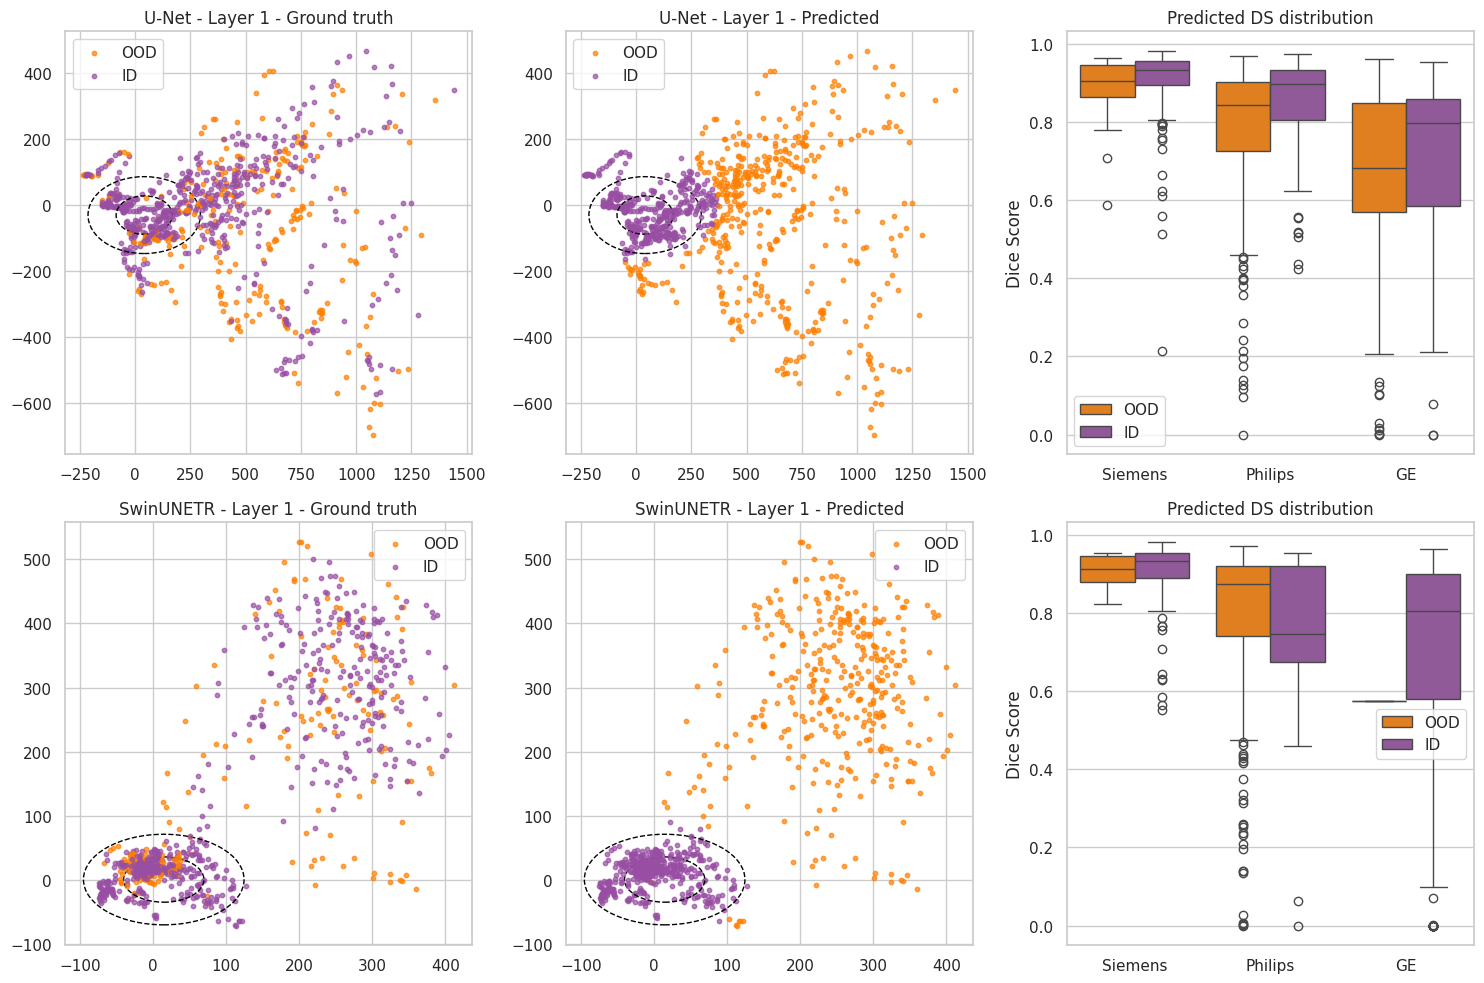

In [10]:
plot_multi_pca_features_ood_box(dices_vendor)

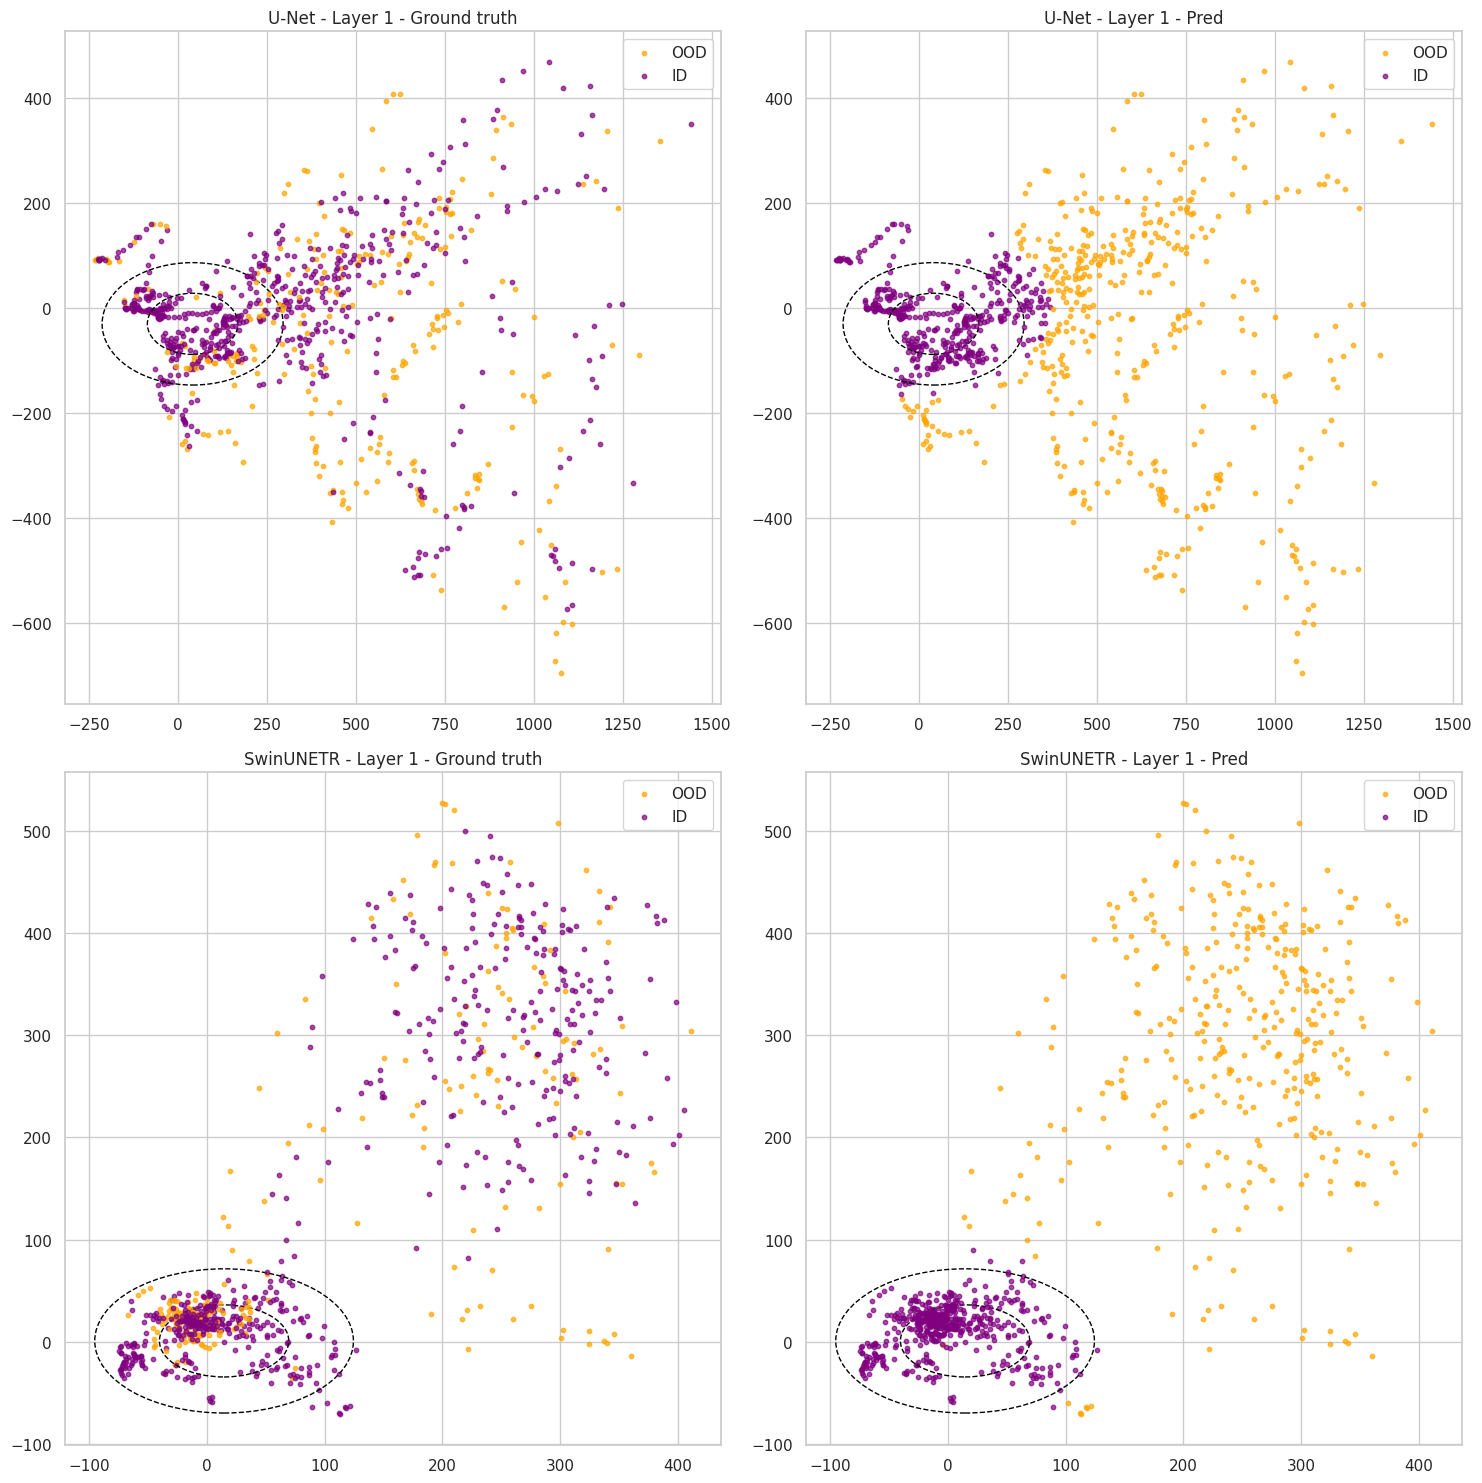

In [11]:
plot_multi_pca_features_ood(dices_vendor)

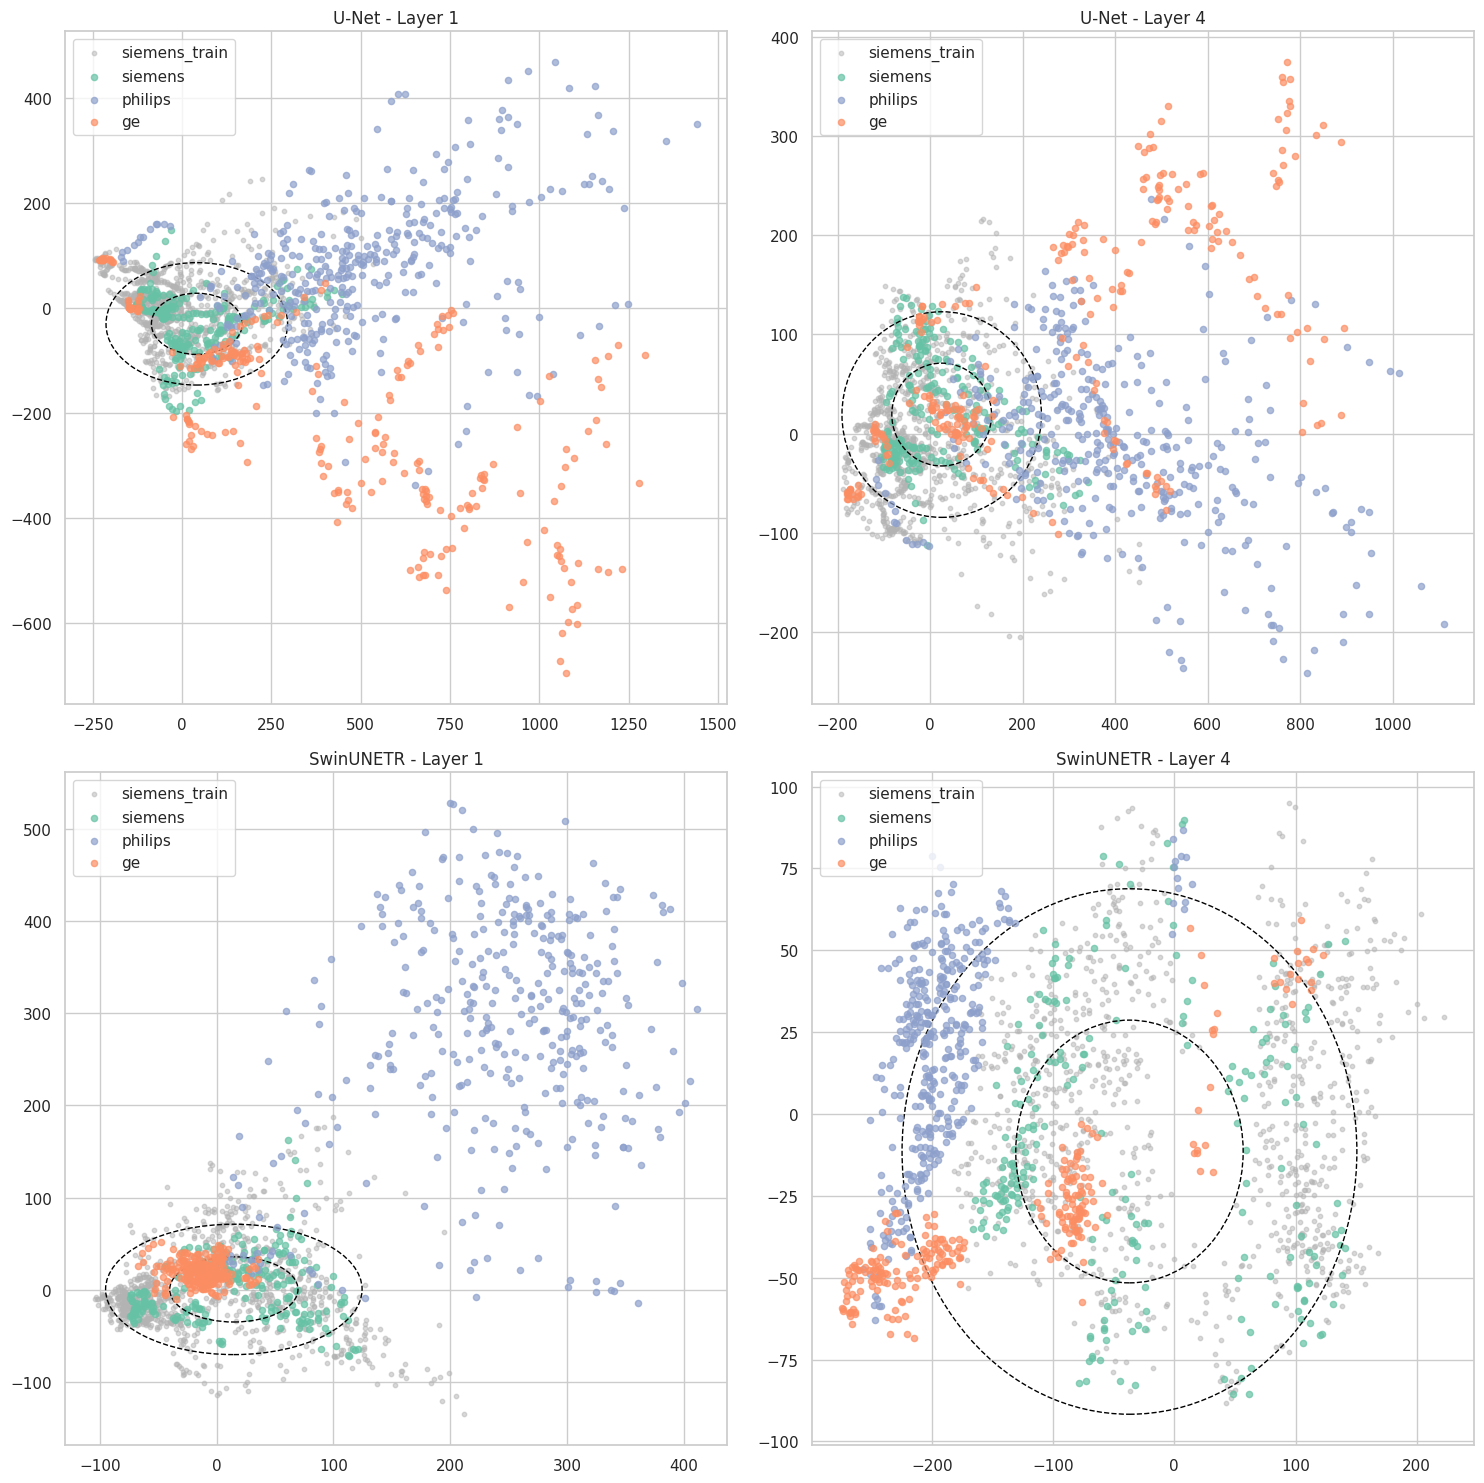

In [12]:
plot_multi_pca_features(dices_vendor)

In [13]:
# for vendor in ['siemens', 'philips', 'ge']:
#     for model in models:
#         tmp_md_data = dices_vendor[vendor][model]['md']
#         for lay in tmp_md_data:
#             if lay not in ['encoder2', 'encoder10', 'model.0.conv', 'model.1.submodule.1.submodule.1.submodule.0.conv']:
#                 continue
#             print(f"PCA: {vendor} - {model} - {lay}, md_mean: {np.mean(tmp_md_data[lay]):.4f}, md_std: {np.std(tmp_md_data[lay]):.4f}")
#         tmp_md_data = dices_vendor[vendor][model]['md_avg']
#         for lay in tmp_md_data:
#             if lay not in ['encoder2', 'encoder10', 'model.0.conv', 'model.1.submodule.1.submodule.1.submodule.0.conv']:
#                 continue
#             print(f"AVG: {vendor} - {model} - {lay}, md_mean: {np.mean(tmp_md_data[lay]):.4f}, md_std: {np.std(tmp_md_data[lay]):.4f}")

In [14]:
# dices_vendor['siemens']['swinunetr']['md']
# plot_pca_features(dices_vendor, "monai-64-4-4", "model.1.submodule.1.submodule.2.0.conv")

#### Segmentation plots

In [39]:
def plot_idx(idx_siem, idx_phil, idx_ge):
    sns.set_theme(style="whitegrid")
    # For ground truth (yellow)
    yellow_cmap = plt.cm.YlOrBr
    yellow_colors = yellow_cmap(np.arange(yellow_cmap.N))
    yellow_colors[:, -1] = np.linspace(0, 1, yellow_cmap.N)  # Set alpha gradient
    yellow_colors[0, -1] = 0  # Make zero values fully transparent
    yellow_cmap = ListedColormap(yellow_colors)

    # For prediction (cyan)
    cyan_cmap = plt.cm.winter
    cyan_colors = cyan_cmap(np.arange(cyan_cmap.N))
    cyan_colors[:, -1] = np.linspace(0, 1, cyan_cmap.N)
    cyan_colors[0, -1] = 0
    cyan_cmap = ListedColormap(cyan_colors)
    fig, axes = plt.subplots(3, 5, figsize=(10, 6))
    i = 0
    for ven in test_vendors:
        if 'phil' in ven: arbitrary_idx = idx_phil
        elif 'siem' in ven: arbitrary_idx = idx_siem
        elif 'ge' in ven: arbitrary_idx = idx_ge
        print(ven, arbitrary_idx)
        if i == 0:
            axes[i][0].set_title('Image', fontsize=10)
            axes[i][1].set_title('Target', fontsize=10)
            axes[i][2].set_title('Predicted', fontsize=10)
            axes[i][3].set_title('Difference', fontsize=10)
            axes[i][4].set_title('Overlay', fontsize=10)
        img_data = all_eval_data[ven][arbitrary_idx]['input'][0, ...]
        tar_data = all_eval_data[ven][arbitrary_idx]['target'][0, ...]
        axes[i, 0].imshow(img_data, cmap='gray')
        axes[i, 1].imshow(tar_data, cmap='gray')
        img = dices_vendor[ven]['monai-64-4-4']['seg'][arbitrary_idx]
        print(ven, dices_vendor[ven]['monai-64-4-4']['DS'][arbitrary_idx])
        axes[i, 2].imshow(img[0, ...], cmap='gray')
        diff = torch.abs(img[0, ...] - all_eval_data[ven][arbitrary_idx]['target'][0, ...])
        axes[i, 3].imshow(diff, cmap='gray')
        axes[i, 4].imshow(img_data, cmap='gray')
        axes[i, 4].imshow(img[0, ...], cmap=cyan_cmap, alpha=(img[0, ...].numpy() > 0).astype(float) * 0.5, interpolation='none')
        axes[i, 4].imshow(tar_data, cmap='Oranges', alpha=(tar_data.numpy() > 0).astype(float) * 0.5, interpolation='none')
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')
        axes[i, 2].axis('off')
        axes[i, 3].axis('off')
        axes[i, 4].axis('off')
        i += 1
    fig.text(0.1, 0.75, 'Siemens', ha='center', va='center', rotation='vertical', fontsize=10)
    fig.text(0.1, 0.45, 'Philips', ha='center', va='center', rotation='vertical', fontsize=10)
    fig.text(0.1, 0.17, 'GE', ha='center', va='center', rotation='vertical', fontsize=10)
    # plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.tight_layout(rect=[0.1, 0, 1, 1])
    plt.savefig('/workspace/out/plots/seg_mask_example.png', dpi=1200, bbox_inches='tight')
    plt.show()
    

siemens 30
siemens 0.9628461
philips 25
philips 0.64910024
ge 67
ge 0.077892326


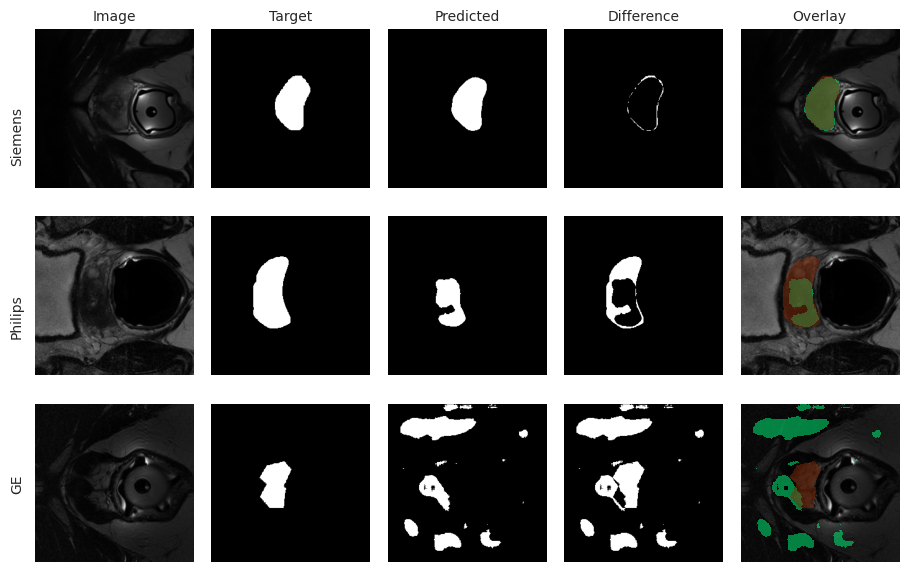

In [40]:
plot_idx(30, 25, 67)

siemens 97
siemens 0.96493983
philips 122
philips 0.925212
ge 116
ge 0.94736844


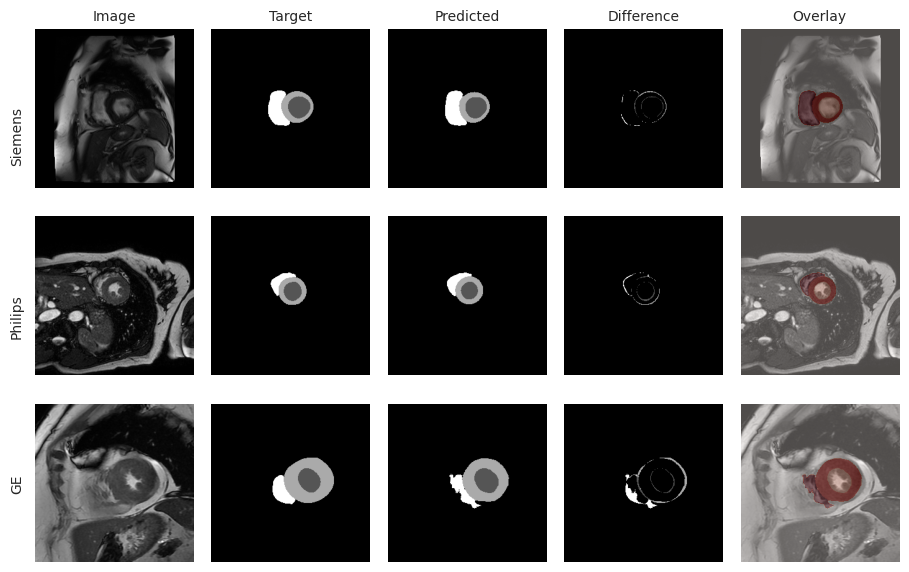

In [17]:
plot_idx(97, 122, 116)

#### Dice score distribution plot

/tmp/ipykernel_3579247/3049950628.py:15: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.boxplot(x='Model', y='Dice', hue='Vendor', data=df, palette=palette)


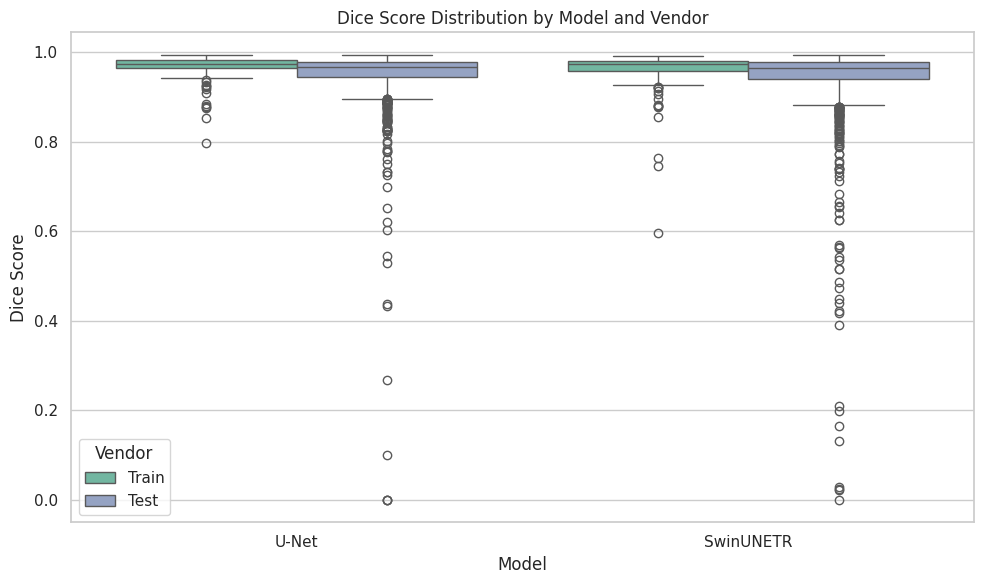

In [16]:
boxplotdata = []
for ven in test_vendors:
    for model in models:
        for d in dices_vendor[ven][model]['DS']:
            boxplotdata.append(
                {
                    "Vendor": ven.capitalize() if ven != "ge" else "GE",
                    "Model": "U-Net" if "monai" in model else "SwinUNETR",
                    "Dice": d
                }
            )

df = pd.DataFrame(boxplotdata)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='Dice', hue='Vendor', data=df, palette=palette)

# Customize the plot
plt.title('Dice Score Distribution by Model and Vendor')
plt.xlabel('Model')
plt.ylabel('Dice Score')
plt.legend(title='Vendor')

# Show the plot
plt.tight_layout()
plt.show()
        

In [37]:
sns.palettes.color_palette("Set1")

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6, 0.6, 0.6)]

/tmp/ipykernel_2129531/3770961642.py:19: UserWarning: The palette list has more values (9) than needed (2), which may not be intended.
  sns.boxplot(x="VendorModel", y="Dice_Score", hue="Dice_Type", data=df_box_id,


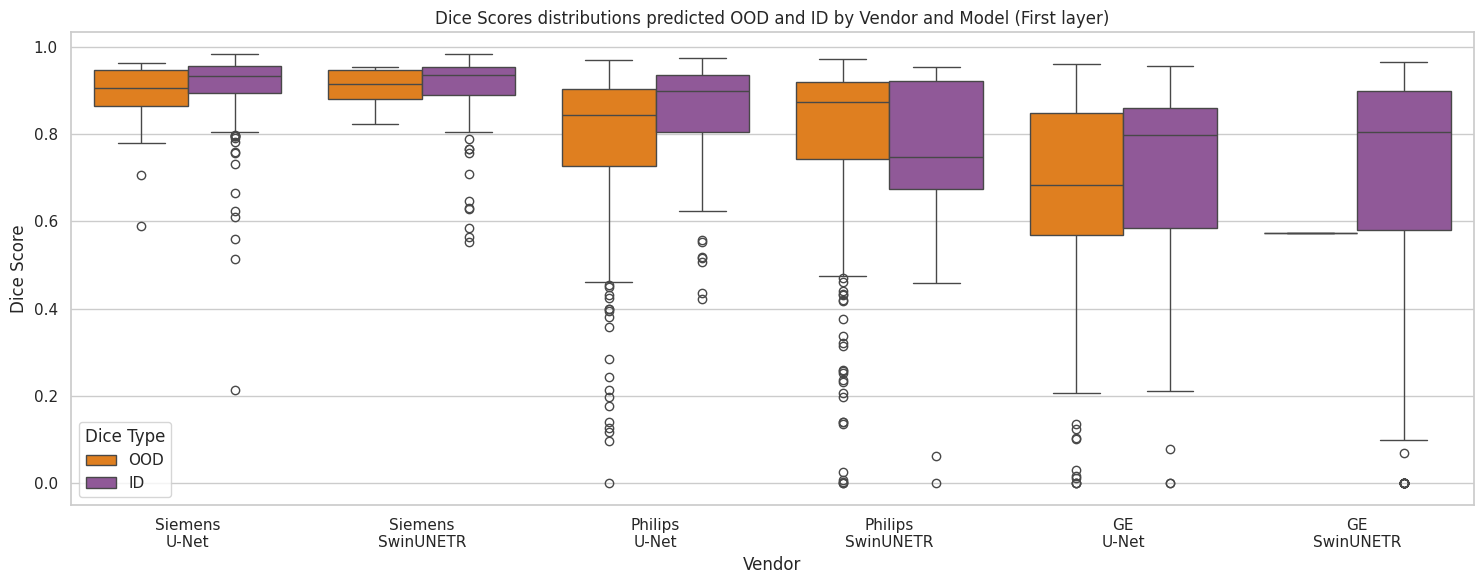

In [40]:
data = []

for ven in ['siemens', 'philips', 'ge']:
    for model in ["monai-64-4-4", "swinunetr"]:
        ood_scores = dices_vendor[ven][model]["dice_ood"]
        id_scores = dices_vendor[ven][model]["dice_id"]
        for score in ood_scores:
            data.append([f"{ven.capitalize() if ven != 'ge' else 'GE'}\n{'U-Net' if 'monai' in model else 'SwinUNETR'}", 'OOD', score])
        for score in id_scores:
            data.append([f"{ven.capitalize() if ven != 'ge' else 'GE'}\n{'U-Net' if 'monai' in model else 'SwinUNETR'}", 'ID', score])

# Convert to DataFrame
df_box_id = pd.DataFrame(data, columns=["VendorModel", "Dice_Type", "Dice_Score"])

# Create the boxplot
plt.figure(figsize=(15, 6))
tmp_color = sns.palettes.color_palette("Set1")
tmp_color[0], tmp_color[1] = tmp_color[4], tmp_color[3]
sns.boxplot(x="VendorModel", y="Dice_Score", hue="Dice_Type", data=df_box_id, 
            palette=tmp_color, dodge=True)

# Customize the plot
plt.title("Dice Scores distributions predicted OOD and ID by Vendor and Model (First layer)")
plt.xlabel("Vendor")
plt.ylabel("Dice Score")
plt.legend(title="Dice Type", loc='lower left')
plt.tight_layout()

# Show plot
plt.show()

#### Intrinsic PCA data

In [9]:
pcas_path = "/workspace/out/dms"
stats_path = "/workspace/out/eval_data"

In [10]:
data_key = "prostate"
model = "monai-64-4-4"
with open(f"{pcas_path}/{data_key}_{model}_{unet_iter}_base_PCA_model_0_conv.pkl", "rb") as f:
    pca_unet_0 = pickle.load(f)
with open(f"{pcas_path}/{data_key}_{model}_{unet_iter}_base_PCA_model_1_submodule_1_submodule_1_submodule_0_conv.pkl", "rb") as f:
    pca_unet_4 = pickle.load(f)

In [7]:
def plot_pca_exp_variance(pcas):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    for j, pca in enumerate(pcas):
        explained_variance = pca.explained_variance_ratio_
        cumulative_explained_variance = np.cumsum(explained_variance)

        # Create a range for the number of components
        # num_components = np.array([2**i for i in range(10)])
        num_components = np.arange(2, len(explained_variance) + 1, 2)

        # Set seaborn style
        sns.set(style="whitegrid")

        # Create the plot
        sns.lineplot(x=num_components, y=cumulative_explained_variance[1::2], color="b", ax=ax[j])
        num_components = np.array([2**i for i in range(1,10)] + [960])
        sns.scatterplot(x=num_components, y=cumulative_explained_variance[num_components - 1], marker="o", color="b", ax=ax[j])
        ax[j].set_title(f"Layer {4**j}")
        ax[j].set_xlabel("Number of Components")
        ax[j].set_ylabel("Cumulative Explained Variance Ratio")
        ax[j].set_xticks([2, 128, 256, 512, 960])

    # Add titles and labels
    fig.suptitle('Explained Variance vs Number of Components (U-Net PCA adapted)', fontsize=12)

    # Add grid, legend, and axis limits
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()

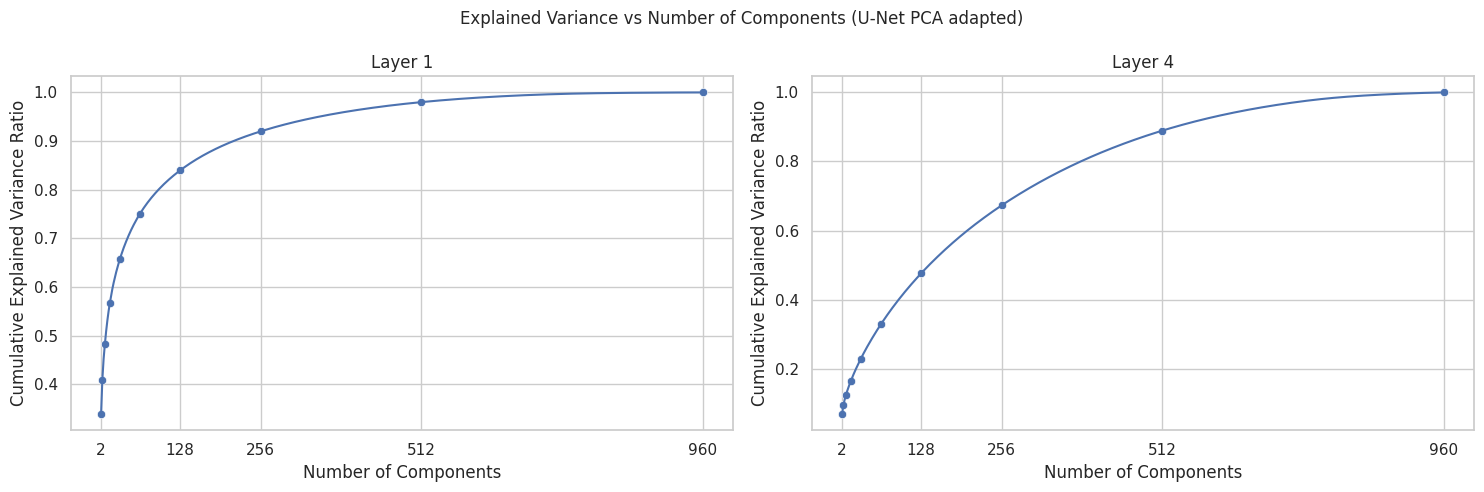

In [11]:
plot_pca_exp_variance([pca_unet_0, pca_unet_4])

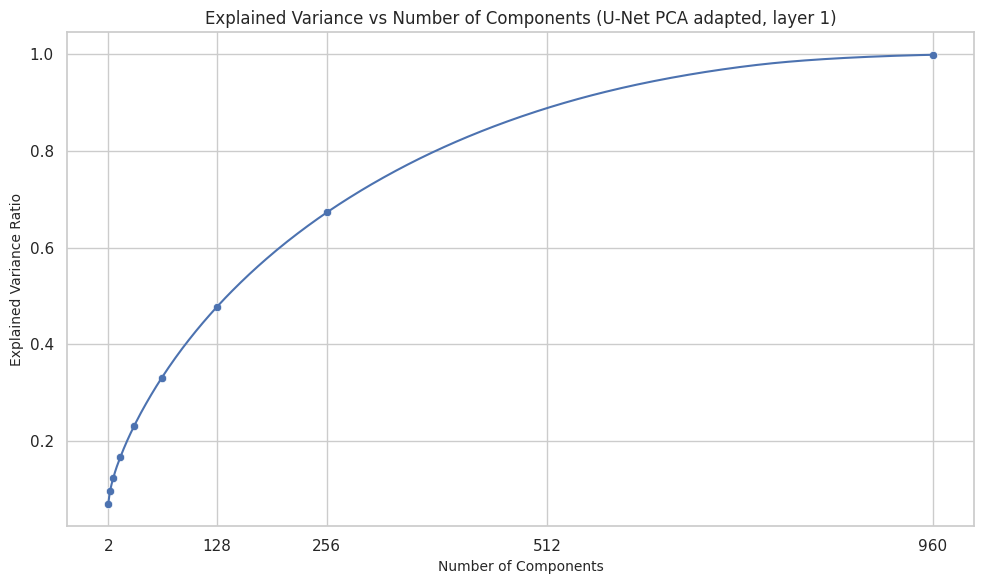

In [51]:
plot_pca_exp_variance(pca_unet_4)

In [3]:
def print_stats(df):
    print("\nAuroc mean per layer & model\n")
    print(df.groupby(['model', 'layer'])['auroc'].mean().reset_index())
    print("\nAuroc mean per num_dims & model\n")
    print(df.groupby(['model', 'n_dims'])['auroc'].mean().reset_index())
    print("\nAuroc mean per dim reduction method\n")
    print(df[df.n_dims > 4].groupby('dim_red_mode')['auroc'].mean().reset_index())
    print("\nAuroc mean IPCA vs PCA comparison\n")
    print(df[df.n_dims <= 4].groupby(['dim_red_mode', 'n_dims'])['auroc'].mean().reset_index().sort_values(by="n_dims"))
    print("\nAuroc mean per dim reduction method and n_dims\n")
    print(df.groupby(['dim_red_mode', 'n_dims'])['auroc'].mean().reset_index().sort_values(by="auroc", ascending=False))
    print("\nAuroc mean by vendor\n")
    print(df.groupby(['vendor', 'model'])['auroc'].mean().reset_index().sort_values(by="auroc", ascending=False))
    print("\nAuroc mean by vendor and method\n")
    print(df.groupby(['vendor', 'dim_red_mode'])['auroc'].mean().reset_index().sort_values(by="auroc", ascending=False))

In [10]:
def print_stats_anomaly(df, word):
    print(df.groupby(['model', 'dim_red_mode', 'n_dims', 'vendor'])[f'auroc_5_{word}', f'auroc_10_{word}', f'auroc_95_{word}'].mean().reset_index().sort_values(by=f"auroc_5_{word}", ascending=False))